# NARPS

In [21]:
%load_ext autoreload
%autoreload 2

import json
from pathlib import Path
from itertools import chain

import numpy as np
import pandas as pd

from nilearn.plotting import plot_design_matrix

import bids
from bids.modeling import BIDSStatsModelsGraph
from bids.layout import BIDSLayout

def api(obj):
    return {attr: getattr(obj, attr) for attr in dir(obj) if not attr[0] == '_'}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
layout = BIDSLayout('./ds001734/', database_path="./ds001734.db")

In [23]:
json_file = './model-narps_smdl.json'
spec = json.loads(Path(json_file).read_text())
spec

{'Name': 'NARPS',
 'Description': 'NARPS Analysis model',
 'BIDSModelVersion': '1.0.0',
 'Input': {'task': 'MGT'},
 'Nodes': [{'Level': 'Run',
   'Name': 'run',
   'GroupBy': ['run', 'subject'],
   'Transformations': {'Transformer': 'pybids-transforms-v1',
    'Instructions': [{'Name': 'Threshold',
      'Input': ['gain'],
      'Binarize': True,
      'Output': ['trials']},
     {'Name': 'Scale',
      'Input': ['gain', 'loss', 'RT'],
      'Demean': True,
      'Rescale': False,
      'Output': ['gain', 'loss', 'demeaned_RT']},
     {'Name': 'Convolve',
      'Model': 'spm',
      'Input': ['trials', 'gain', 'loss', 'demeaned_RT']}]},
   'Model': {'X': ['trials', 'gain', 'loss', 'demeaned_RT', 1], 'Type': 'glm'},
   'DummyContrasts': {'Conditions': ['trials', 'gain', 'loss'], 'Test': 't'}},
  {'Level': 'Subject',
   'Name': 'subject',
   'GroupBy': ['subject', 'contrast'],
   'Model': {'X': [1], 'Type': 'meta'},
   'DummyContrasts': {'Test': 't'}},
  {'Level': 'Dataset',
   'Name': '

In [24]:
spec['Input'] = {
    'task': 'MGT',
    'subject': ['001', '002', '003']
}

In [25]:
graph = BIDSStatsModelsGraph(layout, spec)

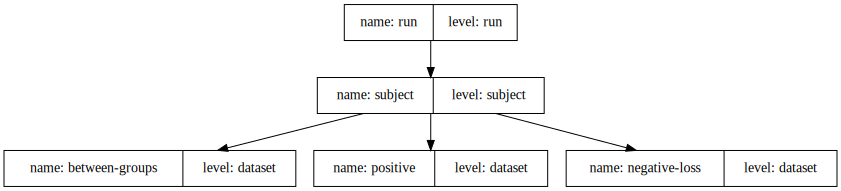

In [26]:
graph.write_graph(format='svg')

In [27]:
root_node = graph.root_node

In [28]:
try:
    graph.load_collections()
except ValueError:
    graph.load_collections(scan_length=453)  # TR = 1, nvols = 453

In [29]:
specs = root_node.run(group_by=root_node.group_by, force_dense=False)

In [30]:
api(specs[0])

{'X':        trials      gain      loss   demeaned_RT  intercept
 0    0.000002 -0.000020 -0.000011  7.939675e-07        1.0
 1   -0.000005  0.000056  0.000032 -2.276861e-06        1.0
 2    0.000014 -0.000159 -0.000091  6.446336e-06        1.0
 3   -0.000037  0.000408  0.000235 -1.654103e-05        1.0
 4    0.000073 -0.000812 -0.000468  3.296583e-05        1.0
 ..        ...       ...       ...           ...        ...
 448  0.729063  8.015666  5.652929 -2.061146e-01        1.0
 449  0.576339  7.628444  4.549625 -1.434993e-01        1.0
 450  0.397427  6.338474  3.218710 -8.201623e-02        1.0
 451  0.237071  4.844265  2.008481 -3.181046e-02        1.0
 452  0.097324  3.315304  0.939883  8.506043e-03        1.0
 
 [453 rows x 5 columns],
 'contrasts': [ContrastInfo(name='gain', conditions=['gain'], weights=[1], test='t', entities={'run': 1, 'subject': '001', 'contrast': 'gain'}),
  ContrastInfo(name='loss', conditions=['loss'], weights=[1], test='t', entities={'run': 1, 'subject': 

In [31]:
specs[0]

In [ ]:
plot_design_matrix(specs[0].X)

In [ ]:
specs[0].entities

In [ ]:
specs[0].metadata

In [ ]:
bold = layout.get(**specs[0].entities, suffix='bold', extension='.nii.gz')[0]

In [ ]:
# import nilearn.glm
# l1m = nilearn.glm.first_level.FirstLevelModel()
# l1m.fit(bold.get_image(), design_matrices=specs[0].X)

In [ ]:
next_node = root_node.children[0].destination

In [ ]:
next_node.group_by

In [ ]:
root_node.children[0].filter

In [ ]:
contrasts = list(chain(*[s.contrasts for s in specs]))
sub_specs = next_node.run(contrasts, group_by=next_node.group_by)

In [ ]:
api(sub_specs[3])

In [ ]:
ds1_node = next_node.children[1].destination
api(ds1_node)

In [ ]:
next_node.children[1].filter

In [ ]:
sub_contrasts = list(chain(*[s.contrasts for s in sub_specs]))
ds1_specs = ds1_node.run(sub_contrasts, group_by=ds1_node.group_by, **next_node.children[1].filter)

In [ ]:
%debug

In [ ]:
ds1_specs[0].X

In [ ]:
pd.concat((ds1_specs[0].data, ds1_specs[0].metadata), axis=1)

In [ ]:
ds1_specs[0].contrasts

In [ ]:
ds0_node = next_node.children[0].destination 
ds0_specs = ds0_node.run(sub_contrasts, group_by=ds0_node.group_by)

In [ ]:
ds0_specs

In [ ]:
ds0_specs[1].X

In [ ]:
pd.concat((ds0_specs[0].data, ds0_specs[0].metadata), axis=1)

In [ ]:
ds2_node = next_node.children[2].destination 
filters = next_node.children[2].filter or {}
print(filters)
ds2_specs = ds2_node.run(sub_contrasts, group_by=ds2_node.group_by, **filters)
print(ds2_specs)

In [ ]:
api(ds2_specs[0])

In [ ]:
ds2_specs[0].X

In [ ]:
pd.concat((ds2_specs[0].data, ds2_specs[0].metadata), axis=1)

In [ ]:
api(ds1_node)

In [ ]:
graph.nodes

In [ ]:
graph.root_node.children

In [ ]:
graph.root_node.children[0].destination.children

In [ ]:
graph.root_node.children[0].destination.children[2].destination.name